<a href="https://colab.research.google.com/github/Dropptimus/lab0/blob/main/practical_0_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import numpy as np

transform = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor()
])

dataset = CIFAR10(root='data/', download=True, transform=transform)
test_data = CIFAR10(root='data/', train=False, transform=transform)

val_size = 5000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])

BATCH_SIZE = 10
SHUFFLE = False
EPOCH = 30


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

Files already downloaded and verified


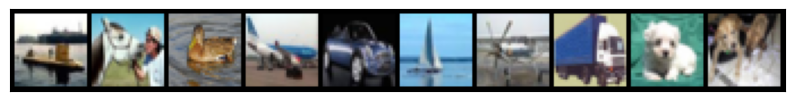

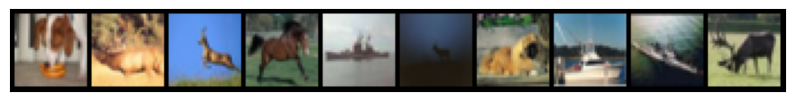

In [28]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    for images,lables in dl:
        fig, ax = plt.subplots(figsize = (10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,10).permute(1,2,0))
        break

# show a batch
show_batch(train_loader)
show_batch(val_loader)

In [29]:
torch.cuda.is_available()

True

In [30]:
import torch.nn as nn

class NetLReLU(nn.Module):
    def __init__(self):
        super(NetLReLU, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.af = nn.LeakyReLU(0.1)
        self.fc1 = nn.Linear(1600, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        # Implement the forward function in the network
        x = self.conv1(x)
        x = self.af(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.af(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = self.af(x)
        x = self.fc2(x)
        return x

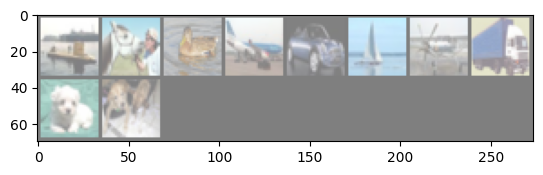

In [31]:
from torch.utils.tensorboard import SummaryWriter

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

writer = SummaryWriter('runs/CIFAR10_3')

dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid)

writer.add_image('ten_CIFAR10_images', img_grid)

#writer.add_graph(model, images)
writer.close()

In [32]:
class NetTanH(nn.Module):
    def __init__(self):
        super(NetTanH, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.af = nn.Tanh()
        self.fc1 = nn.Linear(1600, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        # Implement the forward function in the network
        x = self.conv1(x)
        x = self.af(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = x.flatten(1)
        x = self.af(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.af(x)
        return x

In [33]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs = 10, show_plot = True, run_name = ""):
    min_loss = 10000
    # Track loss
    training_loss, validation_loss = [], []
    # Track accuracy
    training_acc, validation_acc = [], []
    print("Training started!")
    for i in range(num_epochs):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        # Track loss
        epoch_training_loss, epoch_validation_loss = 0, 0
        # track accuracy
        train_correct, val_correct = 0, 0
        # training
        model.train(True)
        print("Train true")
        for batch_nr, (data, labels) in enumerate(train_loader):
            # predict
            data = data.to(device)
            labels = labels.to(device)
            pred = model(data)
            # calculate accuracy
            _,preds = torch.max(pred,dim=1)
            train_correct += torch.sum(preds==labels).item()
            # Clear stored gradient values
            optimizer.zero_grad()
            loss = criterion(pred, labels)
            # Backpropagate the loss through the network to find the gradients of all parameters
            loss.backward()
            # Update the parameters along their gradients
            optimizer.step()
            # Update loss
            epoch_training_loss += loss.cpu().detach().numpy()
            print("batch nr:" , batch_nr, "len", len(train_loader), end='\r')
        # validation
        print("starting validation epoch", i)
        model.eval()
        for batch_nr, (data, labels) in enumerate(val_loader):
            data = data.to(device)
            labels = labels.to(device)
            # predict
            pred = model(data)
            # calculate accuracy
            _,preds = torch.max(pred,dim=1)
            val_correct += torch.sum(preds==labels).item()

            # calculate loss
            loss = criterion(pred, labels)

            # Update loss
            epoch_validation_loss += loss.cpu().detach().numpy()
        # check if loss is smaller than before, if so safe model
        if (epoch_validation_loss/val_size) < min_loss:
            torch.save(model, 'best_model.pt')
            min_loss = epoch_validation_loss
        # Save loss for plot
        training_loss.append(epoch_training_loss/train_size)
        validation_loss.append(epoch_validation_loss/val_size)
        # Save accuracy for plot
        training_acc.append(train_correct/train_size)
        validation_acc.append(val_correct/val_size)
        # Print loss every 5 epochs
        if i % 5 == 0:
            print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
            print(f'Train accuracy = {train_correct/train_size}')
            print(f'Validation accuracy = {val_correct/val_size}')
        writer.add_scalar('training loss',
                        training_loss[-1],
                        i + 1)
        writer.add_scalar('training acc' + run_name,
                        train_correct/train_size,
                        i + 1)
        writer.add_scalar('validation acc' + run_name,
                        val_correct/val_size,
                        i + 1)
        writer.add_scalars('train and validation acc ' + run_name,
                       {"train acc":training_acc[-1], "val acc":validation_acc[-1]},
                       i + 1)

    if show_plot:
        # Plot training and validation loss
        epoch = np.arange(len(training_loss))
        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(epoch, training_loss, 'r', label='Training loss',)
        plt.plot(epoch, validation_loss, 'b', label='Validation loss')
        plt.legend()
        plt.xlabel('Epoch'), plt.ylabel('Loss')
        plt.show()

        # Plot training and validation accuracy
        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(epoch, training_acc, 'r', label='Training accuracy',)
        plt.plot(epoch, validation_acc, 'b', label='Validation accuracy')
        plt.legend()
        plt.xlabel('Epoch'), plt.ylabel('Accuracy')
        plt.show()

    idx = np.argmin(validation_loss)
    print(f'lowest loss for validation set: {np.min(validation_loss)}, with an accuracy of {validation_acc[idx]}')

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_model(model, test_loader, run_name = ""):
    y_pred, y_true = [], []
    test_acc = 0
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for batch_nr, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            labels_mps = labels.to(device)
            pred = model(data)
            _,preds = torch.max(pred,dim=1)
            preds = preds.to("cpu")
            test_acc += torch.sum(preds==labels).item()
            y_pred.extend(preds.numpy())
            y_true.extend(labels.numpy())

    test_acc /= len(test_loader.dataset) / 100

    print(f"Test accuracy is {np.round(test_acc)}%.")
    # Confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
    cm_display.plot(colorbar=False)
    plt.show()

Training started!
Train true
starting validation epoch 0
Epoch 0, training loss: 0.17822115641170078, validation loss: 0.16061685671806336
Train accuracy = 0.3615333333333333
Validation accuracy = 0.4208
Train true
starting validation epoch 1
Train true
starting validation epoch 2
Train true
starting validation epoch 3
Train true
starting validation epoch 4
Train true
starting validation epoch 5
Epoch 5, training loss: 0.12969234668215116, validation loss: 0.13285935450196265
Train accuracy = 0.5434444444444444
Validation accuracy = 0.5298
Train true
starting validation epoch 6
Train true
starting validation epoch 7
Train true
starting validation epoch 8
Train true
starting validation epoch 9
Train true
starting validation epoch 10
Epoch 10, training loss: 0.11442532454861536, validation loss: 0.12432572816610336
Train accuracy = 0.5978
Validation accuracy = 0.5654
Train true
starting validation epoch 11
Train true
starting validation epoch 12
Train true
starting validation epoch 13
Tr

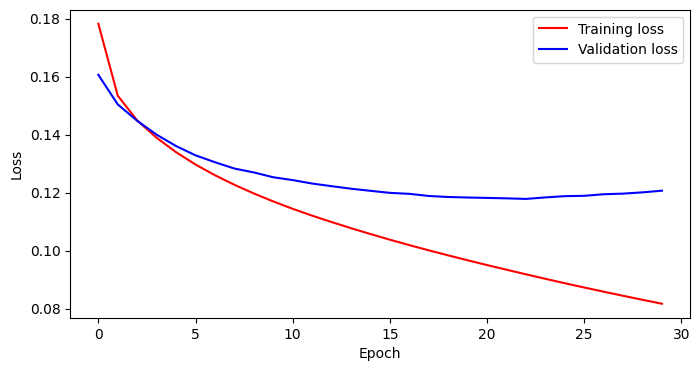

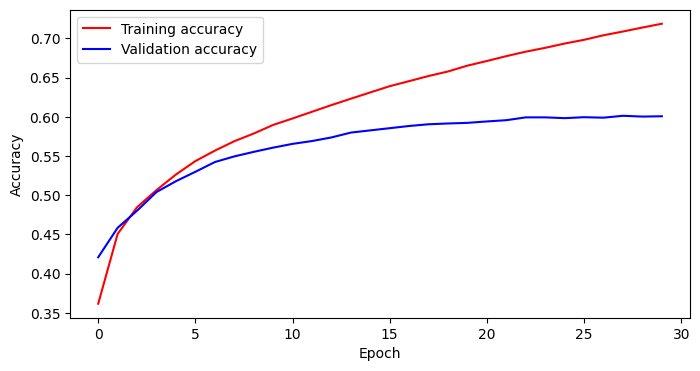

lowest loss for validation set: 0.11784027324318885, with an accuracy of 0.5992
Test accuracy is 60.0%.


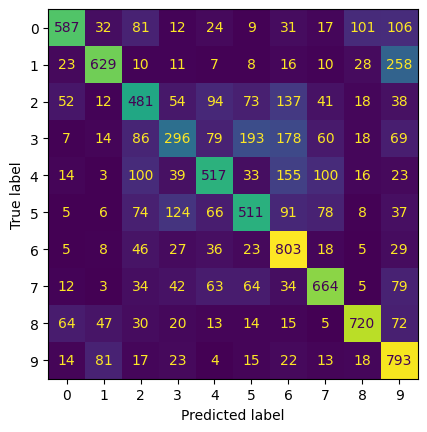

In [35]:

# Hyperparams. Set these to reasonable values
LEARNING_RATE = 0.0001
epochs = EPOCH

# Load our network
model = NetLReLU()

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, epochs, run_name = "LReLU Adam")
model = torch.load('best_model.pt')
test_model(model, test_loader)

Training started!
Train true
starting validation epoch 0
Epoch 0, training loss: 0.22730662134488425, validation loss: 0.21678380401134492
Train accuracy = 0.136
Validation accuracy = 0.2126
Train true
starting validation epoch 1
Train true
starting validation epoch 2
Train true
starting validation epoch 3
Train true
starting validation epoch 4
Train true
starting validation epoch 5
Epoch 5, training loss: 0.16165165270699394, validation loss: 0.1567612342119217
Train accuracy = 0.4282
Validation accuracy = 0.441
Train true
starting validation epoch 6
Train true
starting validation epoch 7
Train true
starting validation epoch 8
Train true
starting validation epoch 9
Train true
starting validation epoch 10
Epoch 10, training loss: 0.13724364125066332, validation loss: 0.13795318435430526
Train accuracy = 0.512
Validation accuracy = 0.5018
Train true
starting validation epoch 11
Train true
starting validation epoch 12
Train true
starting validation epoch 13
Train true
starting validation

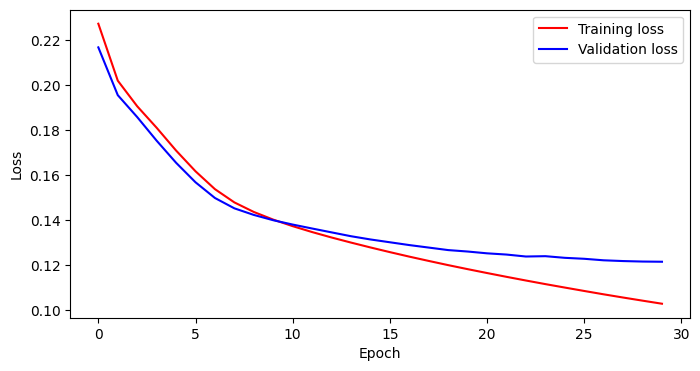

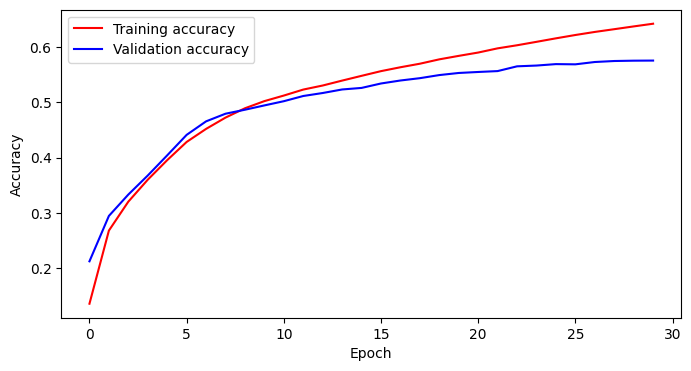

lowest loss for validation set: 0.12141005272865295, with an accuracy of 0.5752
Test accuracy is 58.0%.


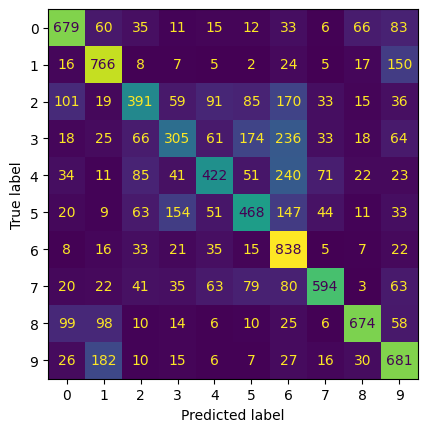

In [36]:

# Hyperparams. Set these to reasonable values
LEARNING_RATE = 0.001
epochs = EPOCH

# Load our network
model = NetLReLU()

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, epochs, run_name = "LReLU SGD")
model = torch.load('best_model.pt')
test_model(model, test_loader)

Training started!
Train true
starting validation epoch 0
Epoch 0, training loss: 0.18948487260341645, validation loss: 0.1812618750810623
Train accuracy = 0.3510666666666667
Validation accuracy = 0.3866
Train true
starting validation epoch 1
Train true
starting validation epoch 2
Train true
starting validation epoch 3
Train true
starting validation epoch 4
Train true
starting validation epoch 5
Epoch 5, training loss: 0.16855291367106967, validation loss: 0.16948263885974885
Train accuracy = 0.45782222222222224
Validation accuracy = 0.4474
Train true
starting validation epoch 6
Train true
starting validation epoch 7
Train true
starting validation epoch 8
Train true
starting validation epoch 9
Train true
starting validation epoch 10
Epoch 10, training loss: 0.1622114448679818, validation loss: 0.16381424391269683
Train accuracy = 0.5005111111111111
Validation accuracy = 0.4926
Train true
starting validation epoch 11
Train true
starting validation epoch 12
Train true
starting validation 

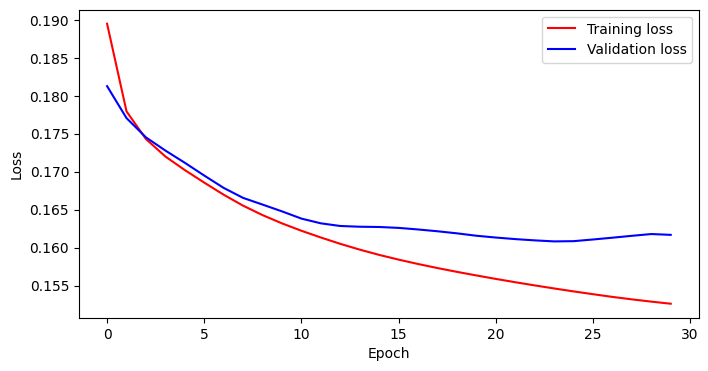

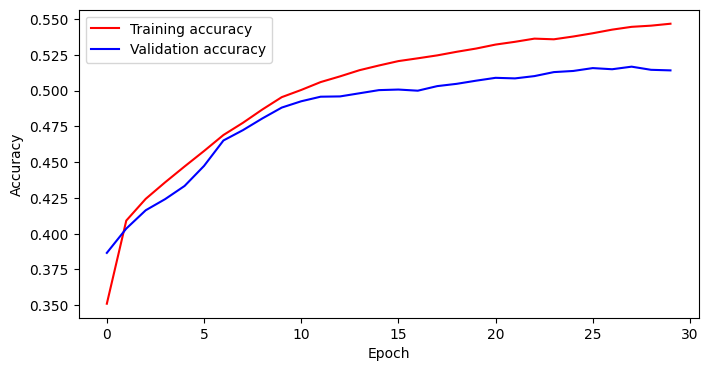

lowest loss for validation set: 0.16081193659305573, with an accuracy of 0.513
Test accuracy is 52.0%.


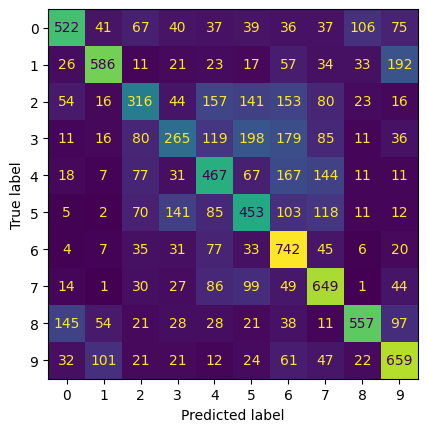

In [37]:

# Hyperparams. Set these to reasonable values
LEARNING_RATE = 0.0001
epochs = EPOCH

# Load our network
model = NetTanH()

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, epochs, run_name = "tanh Adam")
model = torch.load('best_model.pt')
test_model(model, test_loader)

Task 2

In [38]:
transform_alexnet = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

dataset_alexnet = CIFAR10(root='data/', download=True, transform=transform_alexnet)
test_data_alexnet = CIFAR10(root='data/', train=False, transform=transform_alexnet)

val_size = 5000
train_size = len(dataset) - val_size

train_data_alexnet, val_data_alexnet = random_split(dataset_alexnet, [train_size, val_size])

train_loader_alexnet = DataLoader(train_data_alexnet, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
val_loader_alexnet = DataLoader(val_data_alexnet, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_loader_alexnet = DataLoader(test_data_alexnet, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

Files already downloaded and verified


Training started!
Train true
starting validation epoch 0
Epoch 0, training loss: 0.1555643645240201, validation loss: 0.13102216183543205
Train accuracy = 0.4230888888888889
Validation accuracy = 0.5364
Train true
starting validation epoch 1
Train true
starting validation epoch 2
Train true
starting validation epoch 3
Train true
starting validation epoch 4
Train true
starting validation epoch 5
Epoch 5, training loss: 0.048929760999822366, validation loss: 0.0716634534701705
Train accuracy = 0.8276666666666667
Validation accuracy = 0.7664
Train true
starting validation epoch 6
Train true
starting validation epoch 7
Train true
starting validation epoch 8
Train true
starting validation epoch 9
Train true
starting validation epoch 10
Epoch 10, training loss: 0.023514420189949387, validation loss: 0.07907684075604193
Train accuracy = 0.9168666666666667
Validation accuracy = 0.7896
Train true
starting validation epoch 11
Train true
starting validation epoch 12
Train true
starting validation

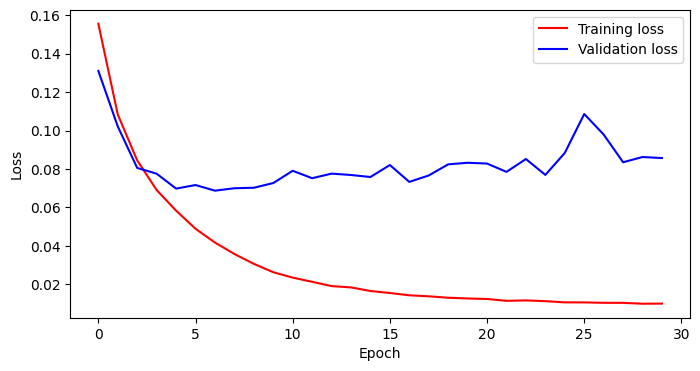

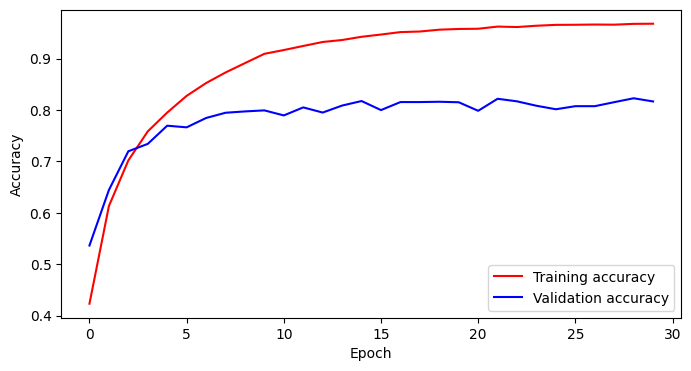

lowest loss for validation set: 0.06873482116116211, with an accuracy of 0.7846
Test accuracy is 81.0%.


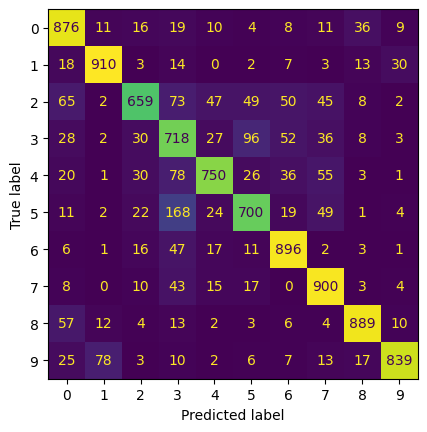

In [39]:

from torchvision.models import AlexNet

LEARNING_RATE = 0.0001
epochs = EPOCH

model = AlexNet(num_classes = 10)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
train_model(model, criterion, optimizer, train_loader_alexnet, val_loader_alexnet, epochs, run_name = "AlexNet")
model = torch.load('best_model.pt')
test_model(model, test_loader_alexnet)
